In [1]:
# Most Code here
import sys
import scipy.misc, scipy.ndimage.interpolation
import pickle
sys.path.append("/opt/saratan/data/layers")
sys.path.append("/opt/saratan/")

import plyvel, saratan_utils, math, re, time
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap('gray')
%matplotlib inline
from IPython import display
import pandas
from PIL import Image,ImageFilter

# ADD VNET STUFF
import VNet as VN
import utilities
import DataManager as DM
import pyLayer
import main
import os
from multiprocessing import Process, Queue
from os.path import splitext
import re



def hist(arr):
    """Print number of pixels for each label in the given image (arr)"""
    return "%.3f , %.3f , %.3f, %.3f" % (np.sum(arr==0),np.sum(arr==1),np.sum(arr==2),np.sum(arr==4))

def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    axis_enabled = kwargs.get('axis',True)

    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        if not axis_enabled:
            plt.axis('off')
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            if not axis_enabled:
                plt.axis('off')
            plt.imshow(args[i], cmap[i], interpolation='none')
    plt.show()
        
def dice(prediction, segmentation, label_of_interest = 1):
    """ Takes 2 2-D arrays with class labels, and return a float dice score.
    Only label=label_of_interest is considered """
    if prediction.shape != segmentation.shape:
        raise ValueError("Shape mismatch between given arrays. prediction %s vs segmentation %s" \
                         % (str(prediction.shape), str(segmentation.shape)))

    n_liver_seg = np.sum(segmentation==label_of_interest)
    n_liver_pred= np.sum(prediction == label_of_interest)
    denominator = n_liver_pred + n_liver_seg
    if denominator == 0:
        return -1

    liver_intersection   = np.logical_and(prediction==label_of_interest, segmentation==label_of_interest)
    n_liver_intersection = np.sum(liver_intersection)

    dice_score = 2.0*n_liver_intersection / denominator
    return dice_score

    
def protobinary_to_array(filename, outpng=None):
    """ Filename is path to protobinary
    outpng is path to output png"""
    with open(filename,'r') as f:
        data = f.read()

    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(data)
    arr = np.array(caffe.io.blobproto_to_array(blob)) #returns shape (1,1,W,H)
    arr = arr[0,0,:,:] #ignore first 2 dimensions
    return  arr

dices_liver = []
dices_lesion= []
def predict(net, img, seg, meanimg):
    """Predicts an img using the trained net, and compares it to the label image (seg)"""
    net.blobs['data'].data[0]=(img-meanimg)
    prob=net.forward()['prob'][0]
    prediction = np.argmax(prob,axis=0)
    dice_liver = dice(prediction,seg,label_of_interest=1)
    dice_lesion = dice(prediction,seg,label_of_interest=2)
    dices_liver.append(dice_liver)
    dices_lesion.append(dice_lesion)
    print "Dice Liver:", dice_liver
    print "Dice Lesion:",dice_lesion
    print "Prediction class histogram",hist(prediction)
    print "Ground truth class histogram",hist(seg)
    plt.figure(figsize=(20,24))
    plt.subplot(1,3,1); plt.title("Image")
    plt.imshow(img)
    plt.subplot(1,3,2); plt.title("Ground truth")
    plt.imshow(seg)
    plt.subplot(1,3,3); plt.title("Prediction")
    plt.imshow(prediction)
    plt.show()
    
def read_imgs(dbimgit, dbsegit, n=1, print_keys=True):
    """Read img and label after skipping n keys in leveldb. Takes db iterators"""
    for _ in range(n):
        k1,vimg = dbimgit.next()
        k2,vseg = dbsegit.next()
    if print_keys:
        print "Keys:",k1,k2
    img=lutils.to_numpy_matrix(vimg)
    seg=lutils.to_numpy_matrix(vseg)
    return img,seg

def show_kernels(layer_blob_data, fast = False):
    """ Takes solver.net.params['conv1'][0].data and visualize the first channel of all kernels.
    If fast = False : subplots will be used, allowing to see each filter individually, but takes time.
    If fast = True : all filters are plotted in one image"""
    #Input has 4 dims, we only visualize 1st channel of each kernel 
    # (the conv weights that acts on the 1st channel of the input)
    data = layer_blob_data[:,0,:,:]
    if fast:
        raise NotImplementedError("todo")
    
    # Sort
    sorted_data = sorted(data, key=lambda x: np.sum(x))
    data = np.array(sorted_data)
    
    n_kernels = np.array(data).shape[0]
    plot_cols = 20 #number of images in one row
    plot_rows = math.ceil(n_kernels*1.0 / plot_cols)
    # Adjust figure plot size
    plt.figure(figsize=(min(plot_cols, n_kernels)*0.7, plot_rows*0.7))
    # Plot !
    vmin = np.min(data)
    vmax = np.max(data)
    print vmin,vmax
    for i in range(n_kernels):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.imshow(data[i], interpolation='none', vmin=vmin, vmax=vmax)
        plt.axis("off")
    plt.show()
        
def plot_deepliver_log(fname):
    """Takes file handle of deepliver log, and plots the 4 plots :
    Loss, avgAccuracy, avgJaccard, avgRecall"""
    f = open(fname, 'r')
    logs = f.read()
    plt.figure(figsize=(10,10))
    # Get iterations
    iterations = re.findall("Iteration (\d+), loss",logs)

    # Get&plot loss
    loss = zip(*re.findall("Iteration \d+, loss = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",logs))[0]
    length = min(len(iterations), len(loss))
    iterations_trunc, loss_trunc = iterations[:length], loss[:length]
    plt.plot(iterations,loss,label='Loss')
    #plt.show()
    #Get&plot metrics
    metrics = ['Accuracy','Recall','Jaccard']
    data = defaultdict(list) # data.keys() = metrics , data[metrics[0]] = list of values
    for i,metric in enumerate(metrics):
        regex = "Train net output #"+str(i)+": accuracy = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
        for result in re.findall(regex,logs):
            data[metric].append(result[0])

    for metric in data.keys():
        length = min(len(iterations),len(data[metric]))
        iterations_trunc, data_trunc = iterations[:length], data[metric][:length]
        plt.plot(iterations_trunc, data_trunc,label=metric)
        plt.legend(loc="lower center",prop={'size':15})
    f.close()


def histeq(im,nbr_bins=256):
    """Histogram equalization"""
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape)

def imshow_overlay_segmentation(him,img,seg,pred):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(himg)
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(img); plt.hold(True)
    plt.imshow(seg, cmap="Blues", alpha=0.3)
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(img); plt.hold(True)
    plt.imshow(pred, cmap="Reds", alpha=0.3)
    plt.show()

# Javascript for endless cell size

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
import caffe
print caffe.__file__
caffe.set_mode_gpu()

/opt/caffe/python/caffe/__init__.pyc


# Load Params and NET

In [4]:
cwd=os.getcwd()
basePath='/media/nas/03_Users/01_patrickchrist/vnet'
params = dict()
params['DataManagerParams']=dict()
params['ModelParams']=dict()
params['Augmentation']=dict()

#params of the algorithm
params['ModelParams']['numcontrolpoints']=4
params['ModelParams']['sigma']=8
params['ModelParams']['device']=0
params['ModelParams']['prototxtTrain']=os.path.join(cwd,'Prototxt/train_noPooling_ResNet_cinque.prototxt')
params['ModelParams']['prototxtTest']=os.path.join(cwd,'Prototxt/test_noPooling_ResNet_cinque.prototxt')
params['ModelParams']['snapshot']=0
params['ModelParams']['dirTrain']='/data/3dircad'
#params['ModelParams']['dirTrain']='/data/3dircad/tmp'
params['ModelParams']['dirTest']='/data/3dircad/test'
params['ModelParams']['dirResult']=os.path.join(basePath,'results') #where we need to save the results (relative to the base path)
params['ModelParams']['dirSnapshots']=os.path.join(basePath,'models/3dircad/') #where to save the models while training
params['ModelParams']['batchsize'] = 1 #the batchsize
params['ModelParams']['numIterations'] = 20000 #the number of iterations
params['ModelParams']['baseLR'] = 0.0001 #the learning rate, initial one
params['ModelParams']['nProc'] = 6 #the number of threads to do data augmentation


#params of the DataManager
params['DataManagerParams']['dstRes'] = np.asarray([4,4,3],dtype=float)
params['DataManagerParams']['VolSize'] = np.asarray([128,128,64],dtype=int)
params['DataManagerParams']['normDir'] = False #if rotates the volume according to its transformation in the mhd file. Not reccommended.
params['DataManagerParams']['label_num'] = 2 # Set label to be loaded from GT, e.g. 1 liver 2 lesion
params['DataManagerParams']['clipping'] = True
params['DataManagerParams']['c_min'] = -100
params['DataManagerParams']['c_max'] = 200

# Augmentation
params['Augmentation']['cascade'] = False
params['Augmentation']['deform_prob'] = 0.8
params['Augmentation']['register_prob'] = 0.5
params['Augmentation']['translate_prob'] = 0.5
model=VN.VNet(params)

# Loading Data and Solver

In [5]:

print params['ModelParams']['dirTrain']

#we define here a data manage object
dataManagerTrain = DM.DataManager(params['ModelParams']['dirTrain'],
                                       params['ModelParams']['dirResult'],
                                       params['DataManagerParams'])

dataManagerTrain.loadTrainingData() #loads in sitk format

howManyImages = len(dataManagerTrain.sitkImages)
howManyGT = len(dataManagerTrain.sitkGT)

assert howManyGT == howManyImages

print "The dataset has shape: data - " + str(howManyImages) + ". labels - " + str(howManyGT)

test_interval = 50000
# Write a temporary solver text file because pycaffe is stupid
with open("solver.prototxt", 'w') as f:
    f.write("train_net: \"" + params['ModelParams']['prototxtTrain'] + "\" \n")
    f.write("base_lr: " + str(params['ModelParams']['baseLR']) + " \n")
    f.write("momentum: 0.99 \n")
    f.write("weight_decay: 0.01 \n")
    f.write("lr_policy: \"step\" \n")
    f.write("stepsize: 5000 \n")
    f.write("gamma: 0.1 \n")
    f.write("display: 1 \n")
    f.write("snapshot: 500 \n")
    f.write("snapshot_prefix: \"" + params['ModelParams']['dirSnapshots'] + "\" \n")
    f.write("test_iter: 3 \n")
    f.write("test_interval: " + str(test_interval) + "\n")
    f.write("test_net: \"" + params['ModelParams']['prototxtTest'] + "\" \n")
            
f.close()
solver = caffe.SGDSolver("solver.prototxt")

if (params['ModelParams']['snapshot'] > 0):
    solver.restore(params['ModelParams']['dirSnapshots'] + "_iter_" + str(
        params['ModelParams']['snapshot']) + ".solverstate")

numpyImages = dataManagerTrain.getNumpyImages()
numpyGT = dataManagerTrain.getNumpyGT()

#numpyImages['Case00.mhd']
#numpy images is a dictionary that you index in this way (with filenames)

for key in numpyImages:
    
    mean = np.mean(numpyImages[key][np.logical_and(numpyImages[key]>0,numpyImages[key]<1)])
    std = np.std(numpyImages[key][np.logical_and(numpyImages[key]>0,numpyImages[key]<1)])

    numpyImages[key]-=mean
    numpyImages[key]/=std


/data/3dircad
FILE LIST: ['image06.nii', 'image08.nii', 'image09.nii', 'image10.nii', 'image12.nii', 'image13.nii', 'image15.nii', 'image16.nii', 'image17.nii', 'image18.nii', 'image19.nii']
GT LIST: ['label06.nii', 'label08.nii', 'label09.nii', 'label10.nii', 'label12.nii', 'label13.nii', 'label15.nii', 'label16.nii', 'label17.nii', 'label18.nii', 'label19.nii']
The dataset has shape: data - 11. labels - 11


# Loading Test Data

In [6]:
dataManagerTest = DM.DataManager(params['ModelParams']['dirTest'], params['ModelParams']['dirResult'], params['DataManagerParams'])
dataManagerTest.loadTestData()


numpyImagesTest = dataManagerTest.getNumpyImages()
numpyGTTest = dataManagerTest.getNumpyGT()

for key in numpyImagesTest:
    mean = np.mean(numpyImagesTest[key][numpyImagesTest[key]>0])
    std = np.std(numpyImagesTest[key][numpyImagesTest[key]>0])

    numpyImagesTest[key] -= mean
    numpyImagesTest[key] /= std



FILE LIST: ['image01.nii', 'image02.nii', 'image03.nii', 'image04.nii', 'image05.nii']
GT LIST: ['label01.nii', 'label02.nii', 'label03.nii', 'label04.nii', 'label05.nii']


# Copy Weights

In [7]:
WEIGHTS_FILE = params['ModelParams']['dirSnapshots'] + "_iter_6500.caffemodel"
#WEIGHTS_FILE = "/media/nas/03_Users/01_patrickchrist/vnet/3dircad-liver-models/3dircad/_iter_18500.caffemodel"
solver.net.copy_from(WEIGHTS_FILE)
solver.test_nets[0].copy_from(WEIGHTS_FILE)

# Multiprocessing for Dataloading and online Augmentation

In [8]:
def prepareDataThread(dataQueue, numpyImages, numpyGT):

        nr_iter = params['ModelParams']['numIterations']
        batchsize = params['ModelParams']['batchsize']

        keysIMG = numpyImages.keys()
        keysGT = numpyGT.keys()
        

        # Create Random pairs of images for augmentation
        nr_iter_dataAug = nr_iter*batchsize
        np.random.seed()
        whichDataList = np.random.randint(len(keysIMG), size=int(nr_iter_dataAug/params['ModelParams']['nProc']))
        whichDataForMatchingList = np.random.randint(len(keysIMG), size=int(nr_iter_dataAug/params['ModelParams']['nProc']))
        

        
        for whichData,whichDataForMatching in zip(whichDataList,whichDataForMatchingList):
            # Load the random pairs of images
            filename, ext = splitext(keysIMG[whichData])
            gtname, ext = splitext(keysGT[whichData])
            
            image_num= re.findall("\d+",filename)[0]
            
            
            currGtKey = "label"+ image_num  + ext
            currImgKey = filename + ext
            
            ImgKeyMatching = keysIMG[whichDataForMatching]

            defImg = numpyImages[currImgKey]
            defLab = numpyGT[currGtKey]
            
            # data agugumentation through hist matching across different examples...
            defImg = utilities.hist_match(defImg, numpyImages[ImgKeyMatching])
            
            
            # Random deform an image to an tamplate
            if(np.random.rand(1)[0]<params['Augmentation']['deform_prob'] ): #do not apply deformations always, just sometimes
                defImg, defLab = utilities.produceRandomlyDeformedImage(defImg, defLab,
                                    params['ModelParams']['numcontrolpoints'],
                                              params['ModelParams']['sigma'])

                
            # Random register an image to an template
            if(np.random.rand(1)[0]<params['Augmentation']['register_prob']): #do not apply deformations always, just sometimes
                defImg, defLab = utilities.produceRegisteredImage(defImg,defLab,numpyImages[ImgKeyMatching])
            
            # Random translation of an image
            if(np.random.rand(1)[0]<params['Augmentation']['translate_prob']): #do not apply deformations always, just sometimes
                defImg, defLab = utilities.produceRandomlyTranslatedImage(defImg,defLab)

            
                
            weightData = np.zeros_like(defLab,dtype=float)
            for label in np.unique(defLab):
                weightData[defLab == label] = np.prod(defLab.shape) / np.sum((defLab==label).astype(dtype=np.float32))
                

                
            #Cascade ToDo
            if params['Augmentation']['cascade']:
                liver_mask=sitk.Cast(sitk.ReadImage(join(self.srcFolder, currGtKey))>0.5,sitk.sitkFloat32)
                #Get the liver index slices
                liver_index_slice=np.non_zeros(liver_mask)[2]
                defImg[~liver_index_slice]=0
                defLab[~liver_index_slice]=0
                weightData[~liver_index_slice]=0
                
            dataQueue.put(tuple((defImg,defLab, weightData)))
            
            
dataQueue = Queue(30) #max 50 images in queue
dataPreparation = [None] * params['ModelParams']['nProc']

#thread creation
for proc in range(0,params['ModelParams']['nProc']):
    dataPreparation[proc] = Process(target=prepareDataThread, args=(dataQueue, numpyImages, numpyGT))
    dataPreparation[proc].daemon = True
    dataPreparation[proc].start()

## Plotting Config
### Config and Initialization

In [9]:
enable_label_2 = False #Set to true when segmenting both liver and lesion (labels=0,1,2)
use_label1_redblue = False # use redblue dice plot. Useful when training cascade Step2 
LOAD_ARRAYS = False # Load arrays from pickled files

if use_label1_redblue:
    label1_color_train, label1_color_test = "blue", "red" 
else:
    label1_color_train, label1_color_test = "#ADB317", "#1C7A34"


PLOT_INTERVAL = 10 # Plot one data point every n iterations
dices = [] #dices for label=1
dices_2 = [] #dices for label=2
dices_test =[] # dices for test
losses= []
accuracies=[]
iterations=[]
test_dices=[]
test_dices_2=[]
test_accuracies=[]
iter = 0
if LOAD_ARRAYS:
    i=                pickle.load(open("i.int",'r'))
    dices=            pickle.load(open("dices.list",'r'))
    if enable_label_2:
        dices_2=          pickle.load(open("dices_2.list",'r'))
        test_dices_2 =    pickle.load(open("test_dices_2.list",'r'))
    losses=           pickle.load(open("losses.list",'r'))
    accuracies=       pickle.load(open("accuracies.list",'r'))
    iterations =      pickle.load(open("iterations.list",'r'))
    test_dices =      pickle.load(open("test_dices.list",'r'))
    test_accuracies = pickle.load(open("test_accuracies.list",'r'))
    
def smooth_last_n(arr, n=5, ignore=None):
    """Replaces the last n elements in arr (list) with their average."""
    subarr = np.array(arr[-n:])
    if ignore != None:
        subarr = subarr[subarr != ignore] 
    mean = np.mean(subarr)
    return arr[:-n]+[mean]

iteration_times = []

# Training

Average solver.step duration is 9.09408710003
Loss 1.53659461737
#### ACCURACY ####
Train Accuracy 0.999535751343
#### DICE ####
Train dice (label=1) 0.768297351456
Test dice (label=2) 0.0720554280038




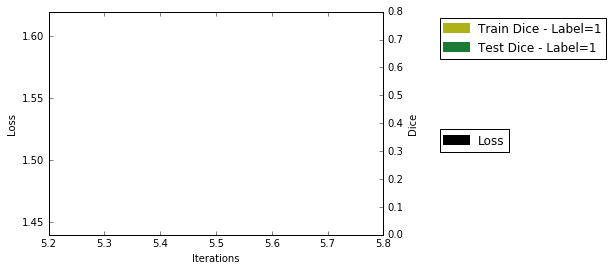

Iteration:10
Train accuracy on last image : 0.999123573303
Train dice Label=1 on last image :  0.832329866813
Test dice Label=1 on last image :  0.00858922052824


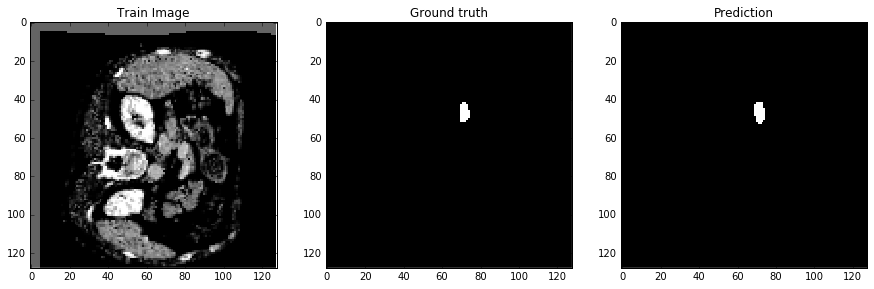

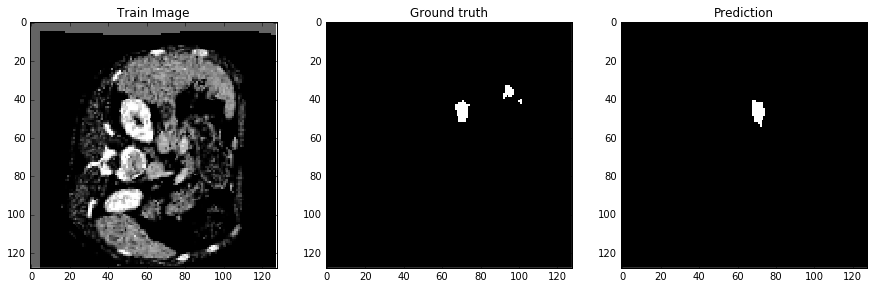

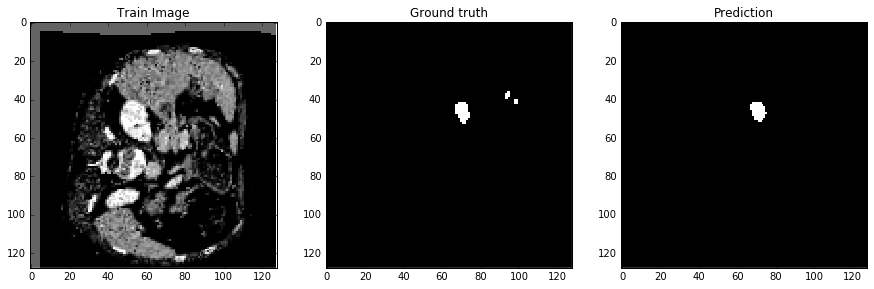

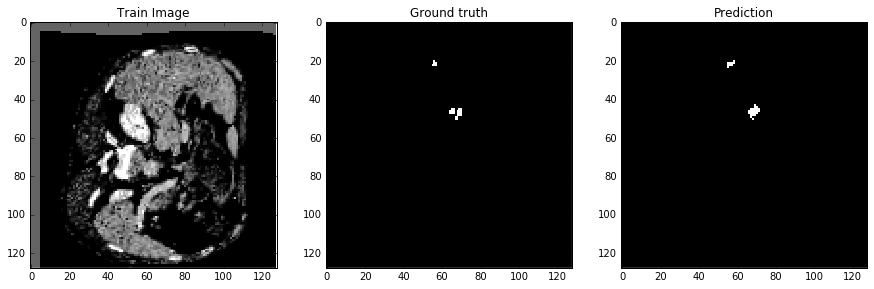

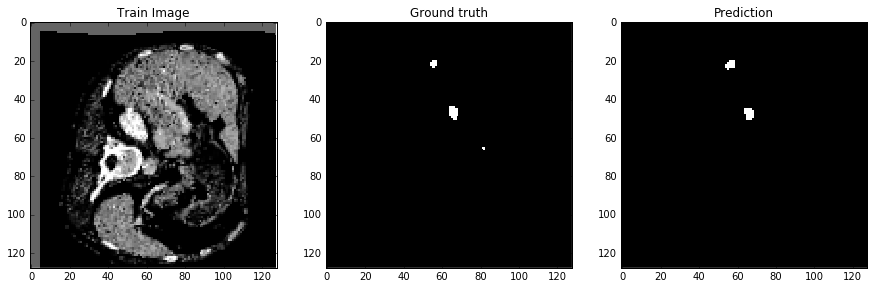

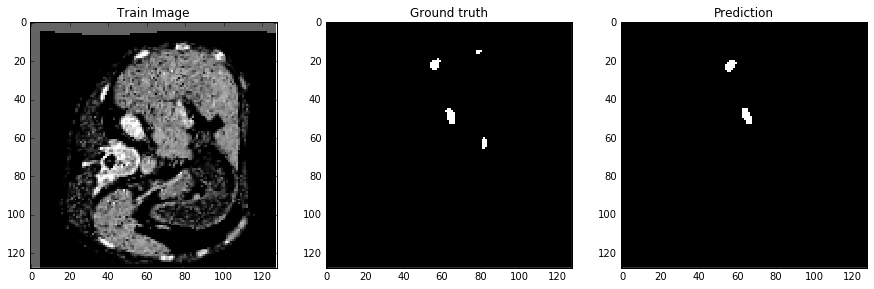

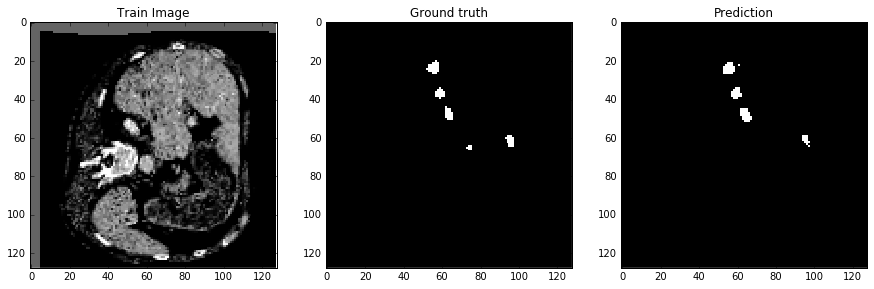

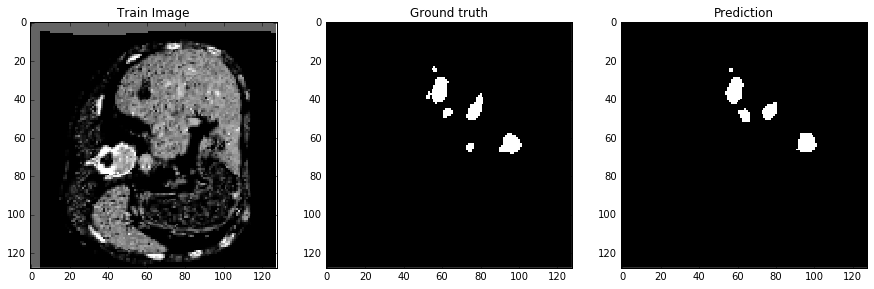

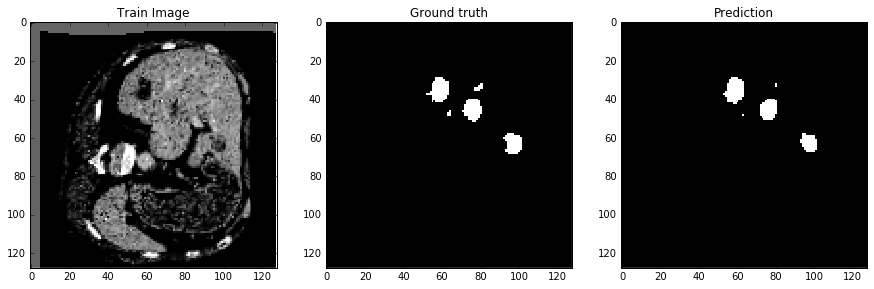

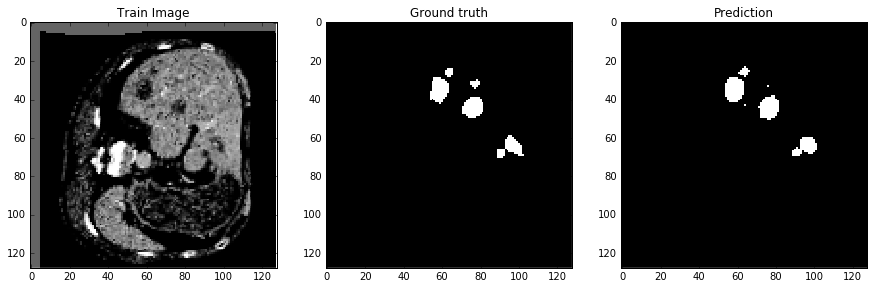

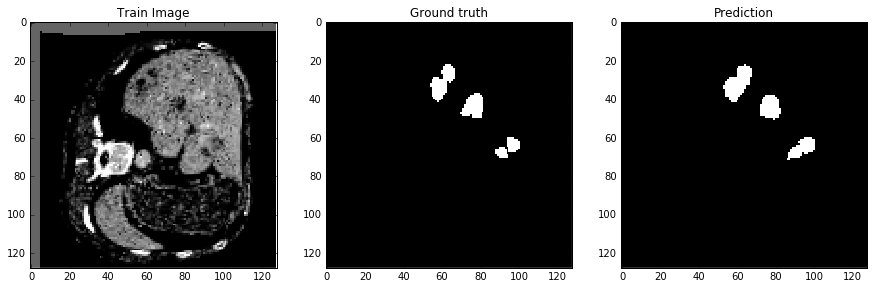

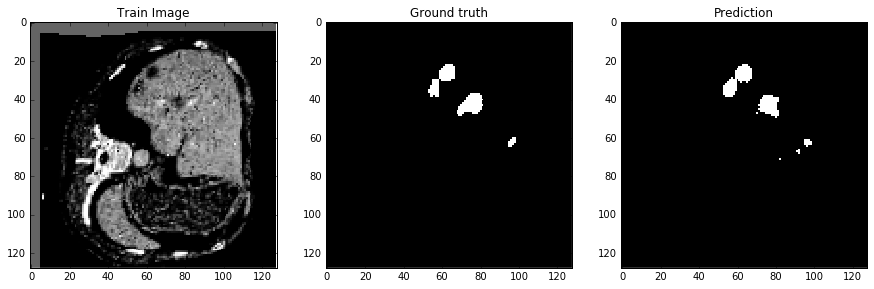

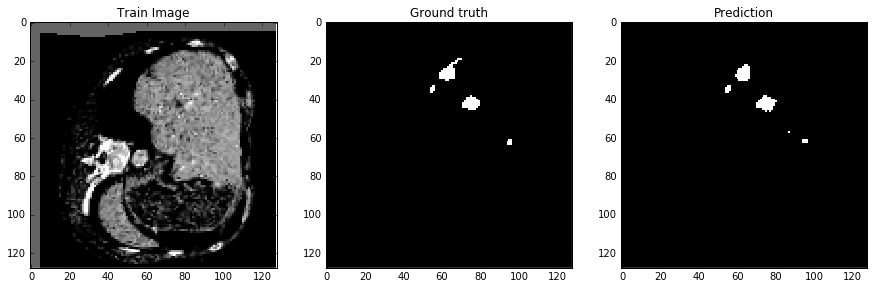

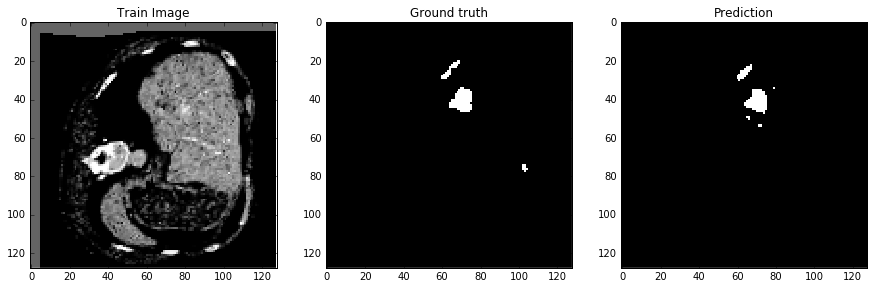

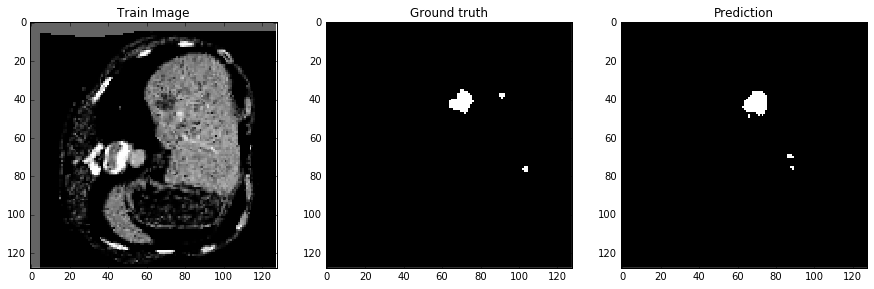

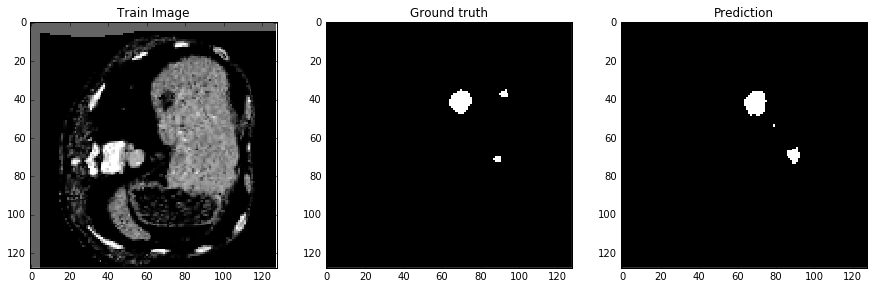

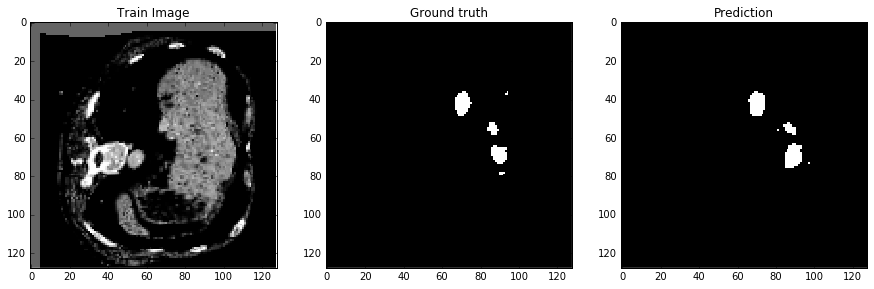

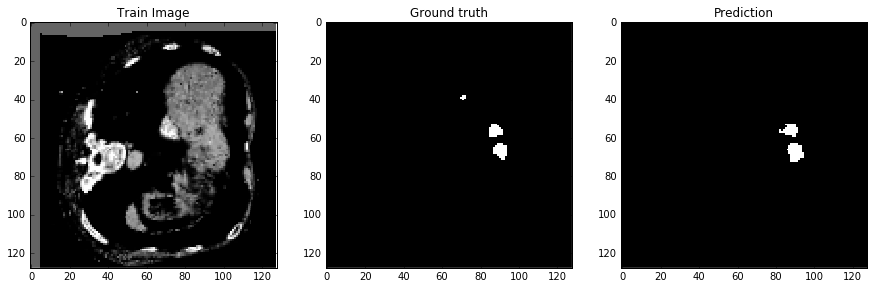

Plotting Test Volumes


TypeError: 'builtin_function_or_method' object has no attribute '__getitem__'

In [10]:
nr_iter = params['ModelParams']['numIterations']
batchsize = params['ModelParams']['batchsize']

batchData = np.zeros((batchsize, 1, params['DataManagerParams']['VolSize'][0], params['DataManagerParams']['VolSize'][1], params['DataManagerParams']['VolSize'][2]), dtype=float)
batchLabel = np.zeros((batchsize, 1, params['DataManagerParams']['VolSize'][0], params['DataManagerParams']['VolSize'][1], params['DataManagerParams']['VolSize'][2]), dtype=float)

#only used if you do weighted multinomial logistic regression
batchWeight = np.zeros((batchsize, 1, params['DataManagerParams']['VolSize'][0],
                       params['DataManagerParams']['VolSize'][1],
                       params['DataManagerParams']['VolSize'][2]), dtype=float)

train_loss = np.zeros(nr_iter)

while iter <nr_iter:
    iter=iter+1
    for i in range(batchsize):
        [defImg, defLab, defWeight] = dataQueue.get()
        print np.min(defImg), np.max(defImg)
        batchData[i, 0, :, :, :] = defImg.astype(dtype=np.float32)
        batchLabel[i, 0, :, :, :] = (defLab > 0.8).astype(dtype=np.float32)
        batchWeight[i, 0, :, :, :] = defWeight.astype(dtype=np.float32)

    solver.net.blobs['data'].data[...] = batchData.astype(dtype=np.float32)
    solver.net.blobs['label'].data[...] = batchLabel.astype(dtype=np.float32)
    #solver.net.blobs['labelWeight'].data[...] = batchWeight.astype(dtype=np.float32)
    #use only if you do softmax with loss



    start_ts = time.time()
    solver.step(1)
    end_ts   = time.time()
    iteration_times.append(end_ts-start_ts)

    # Get metrics
    img = solver.net.blobs['data'].data[0,0]
    seg = np.reshape(solver.net.blobs['label'].data[0,0], img.shape)
    print seg.shape
    pred= np.argmax(solver.net.blobs['softmax_out'].data[0],axis=0).reshape(seg.shape)
    dice_score = dice(pred,seg,1)
    dice_score_2 = dice(pred,seg,2) if enable_label_2 else 0
    accuracy_score = np.sum(seg==pred)*1.0 / seg.size
    loss = float(solver.net.blobs['loss'].data)
    
    #Save metrics values
    iterations.append(iter)
    dices.append(dice_score if dice_score>-1 else 1)
    dices_2.append(dice_score_2 if dice_score_2>-1 else 1)
    accuracies.append(accuracy_score)
    losses.append(loss)
    
    if iter % PLOT_INTERVAL == 0:
        
        ## Run test volumes
        pred_test = dict()
        dices_test =[]

        for key in numpyImagesTest:

            btch = np.reshape(numpyImagesTest[key],[1,1,numpyImagesTest[key].shape[0],numpyImagesTest[key].shape[1],numpyImagesTest[key].shape[2]])

            solver.test_nets[0].blobs['data'].data[...] = btch

            solver.test_nets[0].forward()
    
            pred_tests= np.argmax(solver.test_nets[0].blobs['labelmap'].data[0],axis=0).reshape(seg.shape)
            
            image_num_test_key= re.findall("\d+",key)[0]
            currGtKey_test = "label"+ image_num_test_key  + ".nii"

            pred_test[key] = np.squeeze(pred_tests)
            test_dice=dice(pred_test[key],numpyGTTest[currGtKey_test],1)
            dices_test.append(test_dice)
        

        test_dices.append(np.mean(dices_test))

        display.clear_output(wait=True)
        
        # Print timing stats
        avg_iteration_time = np.mean(iteration_times)
        iteration_times = []
        
        liver_train_dices = []
            
        
        
        # Smooth
        iterations = smooth_last_n(iterations  ,n=PLOT_INTERVAL)
        losses     = smooth_last_n(losses      ,n=PLOT_INTERVAL)
        dices      = smooth_last_n(dices       ,n=PLOT_INTERVAL)
        dices_2    = smooth_last_n(dices_2     ,n=PLOT_INTERVAL) if enable_label_2 else []
        accuracies = smooth_last_n(accuracies  ,n=PLOT_INTERVAL)
        #test_dices      = smooth_last_n(test_dices       ,n=PLOT_INTERVAL)
        
        # Print last metrics
        print "Average solver.step duration is", avg_iteration_time
        print 'Loss',losses[-1]
        print '#### ACCURACY ####'
        print 'Train Accuracy', accuracies[-1]

        print "#### DICE ####"
        print 'Train dice (label=1)',dices[-1]
        print "Test dice (label=2)", test_dices[-1]

        if enable_label_2:
            print 'Train dice (label=2)',dices_2[-1]

        print '\n'
        
        # Plot
        fig, ax1=plt.subplots()
        ax2=ax1.twinx()
        ax1.set_xlabel("Iterations")
        ax2.set_ylabel("Dice")
        ax1.set_ylabel("Loss")
        ax2.plot(iterations, dices, label="Train Dice - Label=1", color=label1_color_train); plt.hold(True) #dark yellow
        ax2.plot(iterations, test_dices, label="Test Dice - Label=1", color=label1_color_test); plt.hold(True)
        ax1.plot(iterations, losses, label="Loss", color="black"); plt.hold(True)
        leg1 = ax2.legend(loc="upper left", bbox_to_anchor=(1.15,1))
        leg2 = ax1.legend(loc="upper left", bbox_to_anchor=(1.15,0.5))
        # Make legend clearer
        for leghandle in leg1.legendHandles+leg2.legendHandles: leghandle.set_linewidth(10.0)
        plt.show()
        
        
        if enable_label_2:
            fig, ax1=plt.subplots()
            ax2=ax1.twinx()
            ax1.set_xlabel("Iterations")
            ax2.set_ylabel("Dice")
            ax1.set_ylabel("Loss")
            ax2.plot(iterations, dices_2, label="Train Dice - Label=2",color="blue"); plt.hold(True) #purple #BC23C4
            ax1.plot(iterations, losses, label="Loss", color="black"); plt.hold(True)
            leg1 = ax2.legend(loc="upper left", bbox_to_anchor=(1.15,1))
            leg2 = ax1.legend(loc="upper left", bbox_to_anchor=(1.15,0.5))
            # Make legend clearer
            for leghandle in leg1.legendHandles+leg2.legendHandles: leghandle.set_linewidth(10.0)
            plt.show()

        print "Iteration:" + str(iter)
        print 'Train accuracy on last image :', np.sum(pred==seg)*1.0/pred.size
        print 'Train dice Label=1 on last image : ', dice(pred,seg,1)
        print 'Test dice Label=1 on last image : ', test_dice
        if enable_label_2:
            print 'Train dice Label=2 on last image : ', dice(pred,seg,2)
        for slice in np.unique(np.nonzero(seg)[2]):
            imshow(img[:,:,slice], seg[:,:,slice], pred[:,:,slice], title=["Train Image", "Ground truth", "Prediction"])
        print "Plotting Test Volumes"
        last_test_key_gt=numpyGTTest.keys()[np.random.randint(len(numpyGTTest.keys()))]
        image_num_test= re.findall("\d+",last_test_key_gt)[0]
        last_test_key_image = "image"+ image_num_test  + ".nii"
        
        for slice_test in np.unique(np.nonzero(numpyGTTest[last_test_key_gt])[2]):
            imshow(numpyImagesTest[last_test_key_image][:,:,slice_test], numpyGTTest[last_test_key_gt][:,:,slice_test], pred_test[last_test_key_image][:,:,slice_test], title=["Test Image", "Ground truth", "Prediction"])

### To resume run this ###

In [ ]:
print len(iterations),len(dices),len(dices_2),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_dices_2),len(test_accuracies)
if not enable_label_2:
    test_dices_2 = test_dices
    dices_2 = dices
#min_len=min(len(iterations),len(dices),len(dices_2),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_dices_2),len(test_accuracies))
min_len=min(len(iterations),len(dices),len(losses),len(accuracies),len(iterations),len(test_dices))
print "Min len",min_len
print 'i',i

In [ ]:
# data agugumentation through hist matching across different examples...
ImgKeyMatching = 'image06.nii'
currImgKey='image08.nii'
currGtKey='label08.nii'
defImg = numpyImages[currImgKey]
defLab = numpyGT[currGtKey]


defImg = utilities.hist_match(defImg, numpyImages[ImgKeyMatching])


In [ ]:
# Random deform an image to an tamplate
if(np.random.rand(1)[0]<params['Augmentation']['deform_prob'] ): #do not apply deformations always, just sometimes
    defImg, defLab = utilities.produceRandomlyDeformedImage(defImg, defLab,
                        params['ModelParams']['numcontrolpoints'],
                                  params['ModelParams']['sigma'])


# Random register an image to an template
if(np.random.rand(1)[0]<params['Augmentation']['register_prob']): #do not apply deformations always, just sometimes
    defImg, defLab = utilities.produceRegisteredImage(defImg,defLab,numpyImages[ImgKeyMatching])

# Random translation of an image
if(np.random.rand(1)[0]<params['Augmentation']['translate_prob']): #do not apply deformations always, just sometimes
    defImg, defLab = utilities.produceRandomlyTranslatedImage(defImg,defLab)

            

In [ ]:
numpyImages[ImgKeyMatching].dtype

In [18]:
numpyGTTest.keys()[np.random.randint(len(numpyGTTest.keys()))]

'label01.nii'

### then this ###

In [ ]:
# In case of resumed training, make sure all lists have equal size. Since kernel interruption might cause them to be 
# not equal
#n_ignored_entries = min_len%PLOT_INTERVAL
#min_len -= n_ignored_entries
if True:
    n_ignored_entries = len(dices) - len(test_dices)
    #min_len = len(dices) - n_ignored_entries
    dices = dices[:min_len]
    dices_2=dices_2[:min_len]
    losses= losses[:min_len]
    accuracies=accuracies[:min_len]
    iterations=iterations[:min_len]
    test_dices=test_dices[:min_len]
    test_dices_2=test_dices_2[:min_len]
    test_accuracies=test_accuracies[:min_len]
    i = len(dices) * PLOT_INTERVAL

print len(iterations),len(dices),len(dices_2),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_accuracies)
print 'i',i

In [ ]:
# In case of resumed training, make sure all lists have equal size. Since kernel interruption might cause them to be 
# not equal
n_ignored_entries = min_len%PLOT_INTERVAL
min_len -= n_ignored_entries


print len(iterations),len(dices),len(dices_2),len(losses),len(accuracies),len(iterations),len(test_dices),len(test_accuracies)
print 'i',i

## ---- End of training notebook (the rest is one-off analysis) ##

In [ ]:
defImg, defLab = utilities.produceRegisteredImage(defImg,defLab,numpyImages[ImgKeyMatching])

In [ ]:
blobs=solver.net.blobs

In [ ]:
td2pure = td2[np.logical_and(td2!=1.0, td2!=0.0)]

In [ ]:
np.count_nonzero(test_dices_2==1.0)

In [ ]:
fidx=1
layer_name='u0c'
for fidx in range(blobs[layer_name].data.shape[1]):
    last_layer_img = blobs[layer_name].data[0,fidx, :,:]
    imshow(last_layer_img)

In [ ]:
for i in iterations:
    print i

In [ ]:
lyr=solver.net.layers[64]
lyr.type
lyr.blobs.__len__()

In [ ]:
for param_name in solver.net.params:
    print param_name,"\t",solver.net.params[param_name][0].data.shape

In [ ]:
show_kernels(solver.net.params["conv_d0a-b"][0].data)

In [ ]:
for idx in range(blobs['d2c'].data.shape[1]):
    imshow(blobs['d2c'].data[0,idx])

In [ ]:
show_kernels(blobs['d0b'].data)

In [ ]:
blobs['data'].data[0,0].shape

In [ ]:
blobs['label'].data[0,0].shape

In [ ]:
print solver.net.params["conv_d0a-b"][0].data.shape
imshow(solver.net.params["conv_d0a-b"][0].data[7,0])

In [ ]:
imshow(blobs['data'].data[0,0][:,:,23])

In [ ]:
imshow(blobs['label'].data[0,0][:,:,23])

In [ ]:
from scipy.signal import convolve2d
filter_idx = 7
image = blobs['data'].data[0,0]
bias = solver.net.params["conv_d0a-b"][1].data[filter_idx]
kernel = solver.net.params["conv_d0a-b"][0].data[filter_idx,0]
result = convolve2d(image, kernel) + bias
print bias
imshow(result)

In [ ]:
import scipy.signal.convolve2d

In [ ]:
print blobs['d0b'].data.shape
imshow(blobs['d0b'].data[0,15],blobs['d0b'].data[0,7])

## Get iteration with best test dice ##

In [ ]:
dice_iter = zip(test_dices,iterations)
dice_iter = sorted(dice_iter, key=lambda t:t[0], reverse=True)
for ji in range(10):
    print str(ji+1)+'th best test Dice:\t',round(dice_iter[ji][0],3),'\tAt iteration:\t',dice_iter[ji][1]

In [ ]:
# Save plots
import pickle
pickle.dump(i, open("i.int",'w'))
pickle.dump(dices, open("dices.list",'w'))
pickle.dump(dices_2, open("dices_2.list",'w'))
pickle.dump(losses, open("losses.list",'w'))
pickle.dump(accuracies, open("accuracies.list",'w'))
pickle.dump(iterations, open("iterations.list",'w'))
pickle.dump(test_dices, open("test_dices.list",'w'))
pickle.dump(test_dices_2, open("test_dices_2.list",'w'))
pickle.dump(test_accuracies, open("test_accuracies.list",'w'))

In [ ]:
mean = protobinary_to_array("mean.protobinary")

## Predicting Training examples ##

In [ ]:
for _ in range(20):
    solver.net.forward()
    img = (blobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = blobs['label'].data[0,0]
    pred= np.argmax(blobs['score'].data[0],axis=0)

    imshow_overlay_segmentation(himg,img,seg,pred)







# Predict TEST examples #

In [ ]:
for _ in range(20):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = testblobs['label'].data[0,0]
    pred= np.argmax(testblobs['score'].data[0],axis=0)

    imshow_overlay_segmentation(himg,img,seg,pred)

# Avg Dice score over slices #

In [ ]:
#dices_lesions_ = []
for _ in range(1000):
    solver.test_nets[0].forward()
    seg = solver.test_nets[0].blobs['label'].data[0,0]
    pred = solver.test_nets[0].blobs['score'].data[0].argmax(0)
    dice_lesion_ = dice(pred,seg,label_of_interest=1)

    if(dice_lesion_ > -1):
        dices_lesions_.append(dice_lesion_)
    print "Average TEST dice lesion: ", np.average(dices_lesions_)

print "FINAL Average TEST dice lesion: ", np.average(dices_lesions_)

# Avg Dice score over individual Lesions #

In [ ]:
import sys
import scipy.spatial.distance
import scipy.ndimage
import scipy.ndimage.measurements
from collections import defaultdict
def dice_separate_lesions(seg,pred, plot=False):
    """Returns Avg dice of lesion structures and weight to assign to this avg dice."""
    #Ignore liver
    if np.unique(seg).size > 2:
        seg[seg==1] = 0
        seg[seg==2] = 1
    if np.unique(pred).size > 2:
        pred[pred==1] = 0
        pred[pred==2] = 1
    # First component is always background
    seg[0,0] = 0
    pred[0,0] = 0
    # Get connected components
    comps_seg, num_comps_seg = scipy.ndimage.label(seg)
    comps_pred, num_comps_pred = scipy.ndimage.label(pred)
    #print 'Found n connected components in ground truth (not including bg) :', num_comps_seg
    if plot: imshow(comps_seg, comps_pred, cmap="Spectral", title=['Components in Ground Truth','Components in Prediction'])
    # Get component centroids
    centroids_seg = scipy.ndimage.measurements.center_of_mass(seg, comps_seg, range(1, num_comps_seg+1))
    centroids_pred = scipy.ndimage.measurements.center_of_mass(pred, comps_pred, range(1, num_comps_pred+1))
    # round to nearest 2 decimals (otherwise we might have problems removing from list by-value due to fp inaccuracies)
    centroids_seg = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_seg)
    centroids_pred = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_pred)
    
    def plot_centroids(comps_img, centroids, title, w=5):
        centroid_img = np.ones(comps_img.shape)
        for x,y in centroids:
            centroid_img[x-w:x+w, y-w:y+w] = 0
        plt.title(title)
        plt.imshow(comps_img, cmap="Spectral"); plt.hold(True)
        plt.imshow(centroid_img,cmap="Reds",alpha=0.5)
        plt.show()
    
    
    if plot: plot_centroids(comps_seg, centroids_seg, "Centroids in Ground Truth")
    if plot: plot_centroids(comps_pred, centroids_pred, "Centroids in Prediction")
    
    #### Get Average dice ####
    def get_closest(xy, list_xy, except_at_idx):
        """Returns the index of coordinate in list_xy that is closest to xy (euclidean distance)
        example: get_closest((100,100), [(3,4), (5,9), (101,102), (9999,9999)]) = 2
        because (101,102) is the closest to (100,100).
        except_at_idx is a list of coordinate indices to ignore in list_xy"""
        closest_idx = -1
        min_dist = sys.maxint
        for i, xy_dest in enumerate(list_xy):
            if i in except_at_idx:
                continue
            dist = scipy.spatial.distance.euclidean(xy, xy_dest)
            if dist < min_dist:
                closest_idx = i
                min_dist = dist
        #print xy, map(lambda t:(round(t[0]),round(t[1])),list_xy), closest_idx
        return closest_idx
    
    dices = []
    consumed_lesions_idx = [] #indices of lesions already consumed.
    # Iterate after bg component
    for i in range(num_comps_pred):
        # Add 0 dice to false positives!
        if len(centroids_seg) == 0:
            dices.append(0)
            continue
        current_xy = centroids_pred[i]
        closest_component = get_closest(current_xy, centroids_seg, except_at_idx=consumed_lesions_idx)
        consumed_lesions_idx.append(closest_component)
        #mask out other components 
        one_lesion_pred = np.clip(comps_pred == i, 0, 1)
        one_lesion_seg = np.clip(comps_seg == closest_component, 0, 1)
        dices.append(dice(one_lesion_pred, one_lesion_seg, label_of_interest = 1))
    
    # Add 0 dice for false negatives
    if len(centroids_seg)-len(consumed_lesions_idx) > 0:
        dices.extend([0]*(len(centroids_seg)-len(consumed_lesions_idx)))

    return np.mean(dices), len(dices)

In [ ]:
dices_lesions_ = []
weights = []
for _ in range(200):
    solver.test_nets[0].forward()
    seg = solver.test_nets[0].blobs['label'].data[0,0]
    pred = solver.test_nets[0].blobs['score'].data[0].argmax(0)
    dice_lesion_,weight = dice_separate_lesions(seg,pred)

    if(dice_lesion_ > -1):
        dices_lesions_.append(dice_lesion_)
        weights.append(weight)

total = np.multiply(dices_lesions_, weights)
print "Average TEST dice lesion: ", np.average(total)

## Changing threshold (instead of 0.5) ##

In [ ]:
solver.test_nets[0].forward()
img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
himg =histeq(img)
seg = testblobs['label'].data[0,0]
pred= np.argmax(testblobs['score'].data[0],axis=0)
imshow_overlay_segmentation(himg,img,seg,pred)

In [ ]:
prob = testblobs['prob'].data[0,1]
imshow(prob)
pred_t = prob>0.7
print dice(seg,pred)
print dice(seg,pred_t)
imshow(pred_t,seg)
#prob[np.logical_and(prob>0.4, prob<0.6)].size*1.0/prob.size


#imshow_overlay_segmentation(himg,img,seg,pred)

In [ ]:
def softmax(a1,a2):
    s1 = np.exp(a1)
    s2 = np.exp(a2)
    sm= s1+s2
    return s1/sm , s2/sm

thresholds = np.linspace(0,1,40) #20 thresholds
dices_athalf = []
dices_bythreshold = defaultdict(list) # {0.5:[list of dices], 0.6:[list of dices]}
for _ in range(2000):
    solver.net.forward()
    img = (blobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = blobs['label'].data[0,0]
    prob = softmax(blobs['score'].data[0,0],blobs['score'].data[0,1])[1] #probability being a lesion
    dices_athalf.append(dice(seg,prob>0.5))
    for t in thresholds :
        pred_t = prob > t
        dice_score = dice(seg,pred_t)
        dices_bythreshold[t].append(dice_score)
        
# Aggregate dices over slices for each threshold
avgdices = []
for t in thresholds:
    avgdices.append(np.average(dices_bythreshold[t]))

plt.plot(thresholds,avgdices)
print 'Found max dice at threshold :', thresholds[np.argmax(avgdices)]
print 'Found max dice score :', np.max(avgdices)
print 'Vs. the dice at 0.5 which equals :', np.average(dices_athalf)

In [ ]:
THRESHOLD = 0.820512820513
dices = []
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    seg = testblobs['label'].data[0,0]
    prob = testblobs['prob'].data[0,1] #probability being a lesion
    dice_score = dice(seg,prob> THRESHOLD)
    dices.append(dice_score)
    
print 'Average TEST threshold :', np.average(dices)

In [ ]:
dices = []
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    seg = testblobs['label'].data[0,0]
    pred = np.argmax(testblobs['prob'].data[0], axis=0) #probability being a lesion
    dice_score = dice(seg,pred)
    dices.append(dice_score)
    
print 'Average TEST threshold :', np.average(dices)

In [ ]:
thresholds = np.linspace(0,1,40) #20 thresholds
dices_athalf = []
dices_bythreshold = defaultdict(list) # {0.5:[list of dices], 0.6:[list of dices]}
for _ in range(2000):
    solver.test_nets[0].forward()
    img = (testblobs['data'].data[0,0]+mean)[92:480,92:480]
    himg =histeq(img)
    seg = testblobs['label'].data[0,0]
    prob = testblobs['prob'].data[0,1] #probability being a lesion
    dices_athalf.append(dice(seg,prob>0.5))
    for t in thresholds :
        pred_t = prob > t
        dice_score = dice(seg,pred_t)
        dices_bythreshold[t].append(dice_score)
        
# Aggregate dices over slices for each threshold
avgdices = []
for t in thresholds:
    avgdices.append(np.average(dices_bythreshold[t]))

plt.plot(thresholds,avgdices)
print 'Found max dice at threshold :', thresholds[np.argmax(avgdices)]
print 'Found max dice score :', np.max(avgdices)
print 'Vs. the dice at 0.5 which equals :', np.average(dices_athalf)

# Prototxts #

In [ ]:
!cat solver_unet.prototxt

In [ ]:
!cat unet-overfit.prototxt

In [ ]:
solver.net.blobs.keys()